# Mini-Project 1

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

Gtk-Message: 11:58:49.145: Failed to load module "canberra-gtk-module"


## Usefull functions

In [2]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

In [23]:
###############
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
loadFSL()
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

12:18:36: Debug: Adding duplicate image handler for 'Windows bitmap file'
12:18:36: Debug: Adding duplicate animation handler for '1' type
12:18:36: Debug: Adding duplicate animation handler for '2' type
12:18:36: Debug: Adding duplicate image handler for 'Windows bitmap file'
12:18:36: Debug: Adding duplicate animation handler for '1' type
12:18:36: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:11489): Gtk-CRITICAL **: 12:18:36.548: gtk_window_resize: assertion 'height > 0' failed
12:18:37: Debug: ScreenToClient cannot work when toplevel window is not shown
12:18:37: Debug: ScreenToClient cannot work when toplevel window is not shown
12:18:37: Debug: ScreenToClient cannot work when toplevel window is not shown
12:18:37: Debug: ScreenToClient cannot work when toplevel window is not shown
12:18:37: Debug: ScreenToClient cannot work when toplevel window is not shown
12:18:37: Debug: ScreenToClient cannot work when toplevel window is not shown
12:18:37: De

# Visualization of the data in FSL

In [22]:
fsleyesDisplay.load(op.expandvars('/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/T1w/T1w'))

NameError: name 'fsleyesDisplay' is not defined

In [33]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/fMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR'))


(ipykernel_launcher.py:5430): Gdk-WARNING **: 11:42:21.167: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [34]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/fMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL'))

# Use BIDS standard

In [3]:
dataset_id = 'subject101410'
subject = '101410' 

sample_path = "/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

subject_dir = 'sub-{}'.format(subject)

anat_dir = op.join(bids_root,subject_dir,"anat")
func_dir = op.join(bids_root,subject_dir,"func")

#### TO RUN ONLY IF YOU DON'T HAVE THE STRUCTURE

In [4]:
mkdir_no_exist(bids_root)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'fmap'))

In [37]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-101410/
|------ anat/
|------ func/


#### Now, we have to place the files we have downloaded before in the good directories according to the BIDS standard
#### TO RUN ONLY IF YOU DON'T HAVE THE STRUCTURE

In [5]:
import shutil

# Create the anat and func folders
os.makedirs(anat_dir, exist_ok=True)
os.makedirs(func_dir, exist_ok=True)

anat_src = op.join(bids_root, "T1w", "T1w.nii.gz")
func_root = op.join(bids_root, "fMRI")

# Déplacer et renommer le T1w
anat_dest = op.join(anat_dir, f"sub-{subject}_T1w.nii.gz")
shutil.copy(anat_src, anat_dest)

# Gérer les deux runs fMRI (LR et RL)
fmri_tasks = {
    "tfMRI_MOTOR_LR": "motorLR",
    "tfMRI_MOTOR_RL": "motorRL"
}

for folder, task_name in fmri_tasks.items():
    func_path = op.join(func_root, folder)
    bold_src = op.join(func_path, f"{folder}.nii")
    events_src = op.join(func_path, f"events_{folder.split('_')[-1]}.csv")

    bold_dest = op.join(func_dir, f"sub-{subject}_task-{task_name}_bold.nii.gz")
    events_dest = op.join(func_dir, f"sub-{subject}_task-{task_name}_events.tsv")

    shutil.copy(bold_src, bold_dest)
    shutil.copy(events_src, events_dest)

In [40]:
print_dir_tree(bids_root, max_depth=4)

|subject101410/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|------------ fmap/
|------------ func/
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1w.nii.gz
|------ func/
|--------- sub-101410_task-motorLR_bold.nii.gz
|--------- sub-101410_task-motorLR_events.tsv
|--------- sub-101410_task-motorRL_bold.nii.gz
|--------- sub-101410_task-motorRL_events.tsv


#### Nice! All the files are at the right place with the right name (we don't need the T1w and fMRI folders anymore)

# 1. structural preprocessing

## Skull-Stripping

In [6]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "101410", robust = True)  # To improve the fit

Done with BET.


In [43]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(anat_dir,"sub-101410_T1w"))
fsleyesDisplay.load(resulting_mask_path)

#### Look how good the mask fits the brain. Do manual correction in FSL if needed (see Lab 2)

### Applying the mask

In [7]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    ###########################
    # Solution
    # By reading fslmaths documentation, one can see that the -mas option is exactly what we desire.
    ###########################
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask.nii.gz') # The mask to use

########################
apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [45]:
#fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

## Segmentation

Takes a long time to run

In [8]:
anatomical_path = op.join(bids_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz')
bet_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w')

#########################
# We must apply FAST to the brain-extracted image. Thus we must use the BET path brain.
##########################
fast_target = bet_path 

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-101410', 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [47]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1w.nii.gz
|------ func/
|--------- sub-101410_task-motorLR_bold.nii.gz
|--------- sub-101410_task-motorLR_events.tsv
|--------- sub-101410_task-motorRL_bold.nii.gz
|--------- sub-101410_task-motorRL_events.tsv


The pve files correspond to our segmented tissues. We have exactly three files, because we set n_classes to 3 above:
```python
fast(..., n_classes=3)
```

Let's try to identify which segmentation is which tissue type in the brain. To do this, you'll have to visualize the tissues and decide for yourself.

To make it easier on you, we will display:

- pve_0 in <span style="color:red;">red</span> --> cerebrospinal fluid
- pve_1 in <span style="color:green;">green</span> --> grey matter
- pve_2 in <span style="color:blue;">blue</span> --> white matter

In [48]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

# 2. Functional preprocessing

In [49]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/sub-101410/func/sub-101410_task-motorLR_bold.nii.gz'))

ImageFileError: File /neurodesktop-storage/NSSPMini_Project1/data/subject101410/sub-101410/func/sub-101410_task-motorLR_bold.nii.gz is not a gzip file

## Concatenating

Before merging both runs together, we want to rescale them. The reason is that different runs can have different overall signal intensities or variances, because of: scanner gain or baseline drift, physiological noise changes or small differences in acquisition or head position.

In [9]:
import os
import numpy as np
import nibabel as nib
from nilearn.image import concat_imgs, new_img_like
import matplotlib.pyplot as plt

# Define paths
subject = 'subject101410'

# Raw fMRI runs
runs_info = [
    ('tfMRI_MOTOR_LR', 'tfMRI_MOTOR_LR.nii'),
    ('tfMRI_MOTOR_RL', 'tfMRI_MOTOR_RL.nii')
]

# Output folder for preprocessed/scaled runs
output_dir = os.path.join(preproc_root, 'sub-101410', 'func')
os.makedirs(output_dir, exist_ok=True)

concatenated = [] #merged file

# Process each run independently
for run_name, run_file in runs_info:
    run_path = os.path.join(bids_root, 'fMRI', run_name, run_file)
    img = nib.load(run_path)
    data = img.get_fdata(dtype=np.float32)  # Use float32 to save memory
    
    # Simple brain mask
    brain_mask = data > 0
    global_var = np.var(data[brain_mask], dtype=np.float64)
    
    # Rescale to unit variance
    scaled_data = data / np.sqrt(global_var)
    del data #free memory
    
    # Save scaled run
    output_path = os.path.join(output_dir, f'{subject}_{run_name}_scaled.nii.gz')
    new_img = new_img_like(img, scaled_data)
    new_img.to_filename(output_path)
    print(f'Saved scaled run to: {output_path}')
    concatenated.append(new_img)# merging both runs
    del scaled_data #free memory


concat_img = concat_imgs(concatenated)
concat_img.to_filename(os.path.join(output_dir, 'subject101410_tfMRI_MOTOR_concat_rescaled.nii.gz'))



Saved scaled run to: /home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_LR_scaled.nii.gz
Saved scaled run to: /home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_RL_scaled.nii.gz


In [51]:
concat_path = os.path.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_RL_scaled.nii.gz')
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concat_path)

We will now plot the mean voxel intensity of both runs before and after resacaling. This will show, that we have only changed the variance of the data, but not its realative infromation.

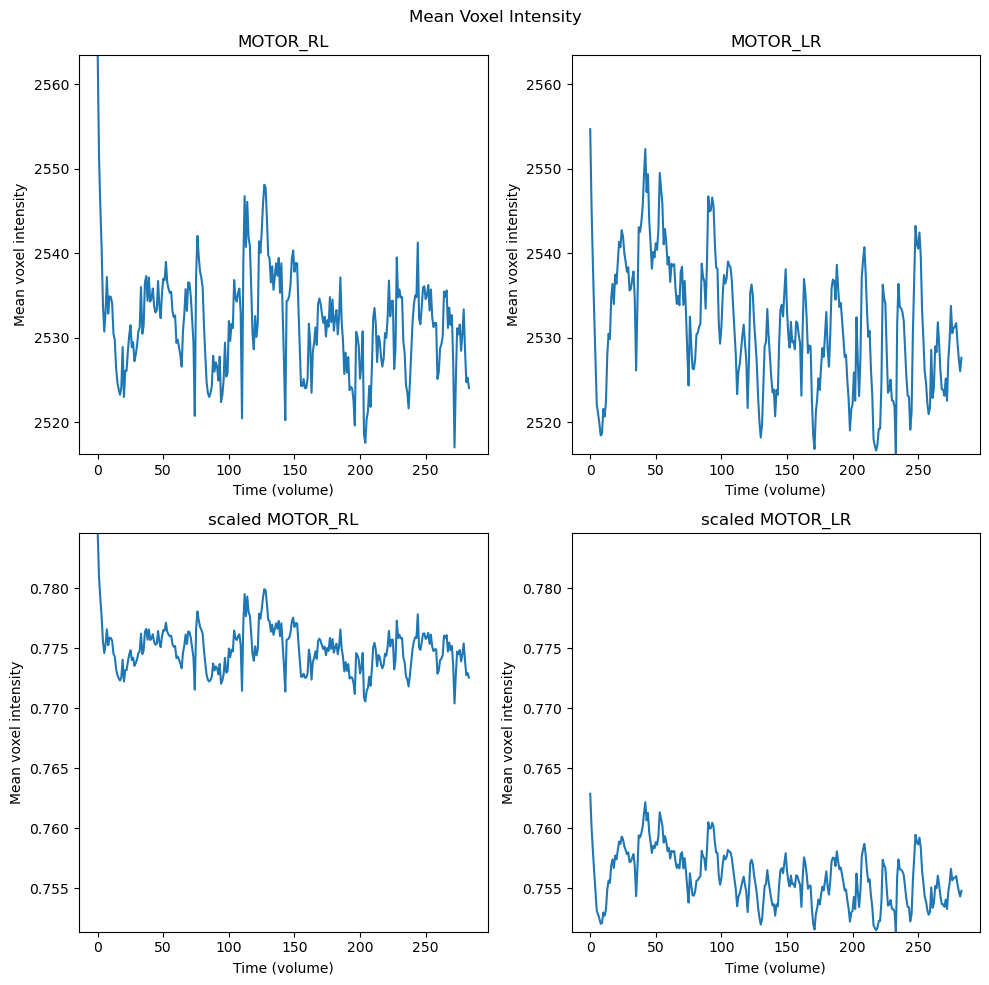

In [10]:
import matplotlib.pyplot as plt
import nibabel as nib
import os.path as op

# Load your data
mean_rl = nib.load(op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_RL', 'tfMRI_MOTOR_RL.nii')).get_fdata().mean(axis=(0,1,2))
mean_lr = nib.load(op.join(bids_root, 'fMRI', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_LR.nii')).get_fdata().mean(axis=(0,1,2))

sc_mean_rl = nib.load(op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_RL_scaled.nii.gz')).get_fdata().mean(axis=(0,1,2))
sc_mean_lr = nib.load(op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_LR_scaled.nii.gz')).get_fdata().mean(axis=(0,1,2))


# Compute global min/max for y-axis alignment
ymin = min(mean_rl.min(), mean_lr.min())
ymax = max(mean_rl.max(), mean_lr.max())

sc_ymin = min(sc_mean_rl.min(), sc_mean_lr.min())
sc_ymax = max(sc_mean_rl.max(), sc_mean_lr.max())


# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Mean Voxel Intensity')

axes[0,0].plot(mean_rl)
axes[0,0].set_title('MOTOR_RL')
axes[0,0].set(xlabel='Time (volume)', ylabel='Mean voxel intensity', ylim=(ymin, ymax))

axes[0,1].plot(mean_lr)
axes[0,1].set_title('MOTOR_LR')
axes[0,1].set(xlabel='Time (volume)', ylabel='Mean voxel intensity', ylim=(ymin, ymax))

axes[1,0].plot(sc_mean_rl)
axes[1,0].set_title('scaled MOTOR_RL')
axes[1,0].set(xlabel='Time (volume)', ylabel='Mean voxel intensity', ylim=(sc_ymin, sc_ymax))

axes[1,1].plot(sc_mean_lr)
axes[1,1].set_title('scaled MOTOR_LR')
axes[1,1].set(xlabel='Time (volume)', ylabel='Mean voxel intensity', ylim=(sc_ymin, sc_ymax))

plt.tight_layout()
plt.show()



## Motion correction

Attention: By default, MCFLIRT selects the middle volume of the EPI serie as reference to which other volumes are realigned.

In [11]:
from fsl.wrappers import mcflirt

# for RL
path_original_data = op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_RL_scaled')
path_moco_data = os.path.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_RL_scaled_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_RL_scaled_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [142] to 8 mm pixels
Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][26

refnum = 142
Original_refvol = -1


Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][118][117][116][115][114][113][112][111][110][109][108][107][106][105][104][103][102][101][100][99][98][97][96][95][94][93][92][91][90][89][88][87][86][85][

{}

In [54]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

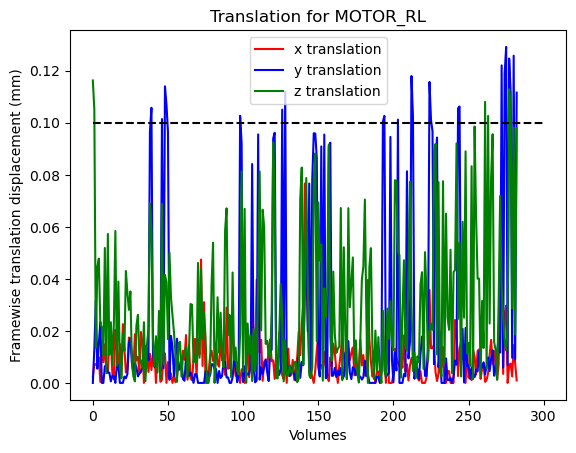

In [12]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_RL_scaled_bold_moco.par'))

# Getting the translation is easy
trans_x = mot_params["Translation x"]
trans_y = mot_params["Translation y"]
trans_z = mot_params["Translation z"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
disp_y = np.diff(trans_y)
disp_z = np.diff(trans_z)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.1
plt.plot(np.abs(disp_x), 'r', label='x translation')
plt.plot(np.abs(disp_y), 'b', label='y translation')
plt.plot(np.abs(disp_z), 'g', label='z translation')

plt.legend()

plt.hlines(threshold, 0, 300,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.title("Translation for MOTOR_RL")
plt.show()

In [13]:
#for LR
path_original_data = op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_LR_scaled')
path_moco_data = os.path.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_LR_scaled_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_LR_scaled_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [142] to 8 mm pixels
Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][26

refnum = 142
Original_refvol = -1


Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][118][117][116][115][114][113][112][111][110][109][108][107][106][105][104][103][102][101][100][99][98][97][96][95][94][93][92][91][90][89][88][87][86][85][

{}

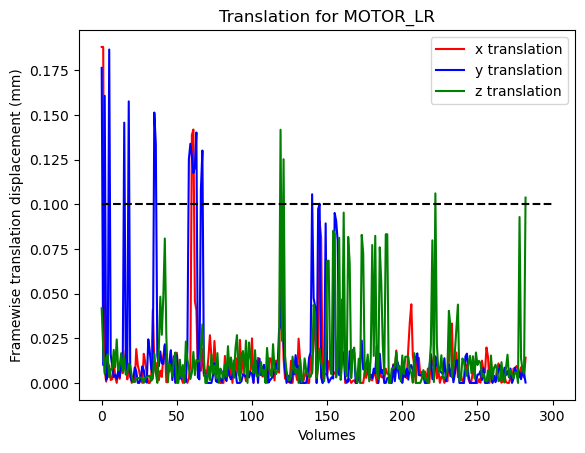

In [14]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.par'))

# Getting the translation is easy
trans_x = mot_params["Translation x"]
trans_y = mot_params["Translation y"]
trans_z = mot_params["Translation z"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
disp_y = np.diff(trans_y)
disp_z = np.diff(trans_z)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.1
plt.plot(np.abs(disp_x), 'r', label='x translation')
plt.plot(np.abs(disp_y), 'b', label='y translation')
plt.plot(np.abs(disp_z), 'g', label='z translation')

plt.legend()

plt.hlines(threshold, 0, 300,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.title("Translation for MOTOR_LR")
plt.show()

## Gaussian smoothing

I am unsure on how to determine the size of our filter. Currently it is 6 mm

In [15]:
import subprocess
output_path = op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.nii.gz')

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.nii.gz', '-s', '2.547987090198743', '/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.nii.gz_smoothed-6mm'], returncode=0)

In [ ]:
smoothed_path = op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.nii.gz_smoothed-6mm')
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path)
fsleyesDisplay.load(smoothed_path)

## Co-registration

In [16]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- subject101410_tfMRI_MOTOR_LR_scaled.nii.gz
|--------------- subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.nii.gz
|--------------- subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.nii.gz_smoothed-6mm.nii.gz
|--------------- subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.par
|--------------- subject101410_tfMRI_MOTOR_RL_scaled.nii.gz
|--------------- subject101410_tfMRI_MOTOR_RL_scaled_bold_moco.nii.gz
|--------------- subject

In [27]:
from fsl.wrappers import epi_reg

#################
# We use the motion corrected EPI 
##################

# We use the motion corrected EPI
epi_source = op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_RL_scaled_bold_moco.nii.gz')

# whole-head T1 (BIDS)
whole_t1 = op.join(bids_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz')

# True brain-extracted T1 using mask already generated
t1_mask = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask.nii.gz')
t1_brain = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_brain.nii.gz')

# Output
output_dir = op.join(preproc_root, 'sub-101410', 'func')
os.makedirs(output_dir, exist_ok=True)
output_path = op.join(output_dir, 'subject101410_tfMRI_MOTOR_RL_scaled_bold_bbr')

# skull_stripped_t1 = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w')
# output_path = op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_RL_scaled_bold_bbr')

# Take middle reference volume
ref_vol_name =  op.join(preproc_root, 'sub-101410', 'func', 'subject101410_tfMRI_MOTOR_RL_scaled_bold_moco_vol_middle.nii.gz')

# Make sure inputs exist
for p in (epi_source, whole_t1, t1_mask):
    if not op.exists(p):
        raise FileNotFoundError(f"Missing: {p}")

# Create a T1 brain image if it doesn't exist yet
if not op.exists(t1_brain):
    subprocess.run(['fslmaths', whole_t1, '-mas', t1_mask, t1_brain], check=True)

# Create the middle-volume file if it doesn’t exist
if not op.exists(ref_vol_name):
    # Determine the middle index from the 4D header
    nvols = nib.load(epi_source).shape[3]
    mid   = nvols // 2
    # fslroi input output t0 nt
    subprocess.run(['fslroi', epi_source, ref_vol_name, str(mid), '1'], check=True)
    assert op.exists(ref_vol_name), "fslroi did not create the middle-volume file"

# Run epi_reg (basic) using single-volume ref and T1 brain
subprocess.run(['epi_reg', f'--epi={ref_vol_name}', f'--t1={whole_t1}', f'--t1brain={t1_brain}', f'--out={output_path}'], check=True)

# if use_single_vol:
#     # Extract the middle volume with fslroi as we've seen before :)
#     fslroi(epi_source, ref_vol_name, str(182), str(1))
#     # Call epi_reg
#     subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])
# else:
#     subprocess.run(['epi_reg','--epi={}'.format(epi_source), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])


Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.984854 0.999266 0.035355 -0.014724 0.000000 -0.036237 0.997241 -0.064780 0.000000 0.012393 0.065266 0.997791 0.000000 2.972608 -12.476552 16.252037 1.000000 


CompletedProcess(args=['epi_reg', '--epi=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_RL_scaled_bold_moco_vol_middle.nii.gz', '--t1=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/sub-101410/anat/sub-101410_T1w.nii.gz', '--t1brain=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/anat/sub-101410_T1w_brain.nii.gz', '--out=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_RL_scaled_bold_bbr'], returncode=0)

In [29]:
###############
# White matter corresponds to pve_2.
##############

white_matter_segmentation = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_fast_pve_2.nii.gz') # We provide the white matter segmentation

if not op.exists(white_matter_segmentation):
    raise FileNotFoundError(f"Missing WM PVE2: {white_matter_segmentation}")

subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(t1_brain), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

FLIRT pre-alignment
Running BBR
0.958939 0.999898 0.014282 0.000965 0.000000 -0.014281 0.999897 -0.001129 0.000000 -0.000981 0.001116 0.999999 0.000000 1.790366 4.660832 1.923284 1.000000 


CompletedProcess(args=['epi_reg', '--epi=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_RL_scaled_bold_moco_vol_middle.nii.gz', '--t1=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/sub-101410/anat/sub-101410_T1w.nii.gz', '--t1brain=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/anat/sub-101410_T1w_brain.nii.gz', '--out=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/func/subject101410_tfMRI_MOTOR_RL_scaled_bold_bbr', '--wmseg=/home/jovyan/neurodesktop-storage/NSSPMini_Project1/data/subject101410/derivatives/preprocessed_data/sub-101410/anat/sub-101410_T1w_fast_pve_2.nii.gz'], returncode=0)

In [30]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(t1_brain)
fsleyesDisplay.load(output_path + "_fast_wmseg.nii.gz")

In [31]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_brain.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- subject101410_tfMRI_MOTOR_LR_scaled.nii.gz
|--------------- subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.nii.gz
|--------------- subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.nii.gz_smoothed-6mm.nii.gz
|--------------- subject101410_tfMRI_MOTOR_LR_scaled_bold_moco.par
|--------------- subject101410_tfMRI_MOTOR_RL_scaled.nii.gz
|--------------- subject101410_tfMRI_MOTOR_RL_sca